# Object Detection

### Project Organization
```
.
├── README.md
├── LICENSE
├── requirements.txt        <- Used to install packages for s2i application
├── 0_start_here.ipynb      <- Instructional notebook
├── 1_run_flask.ipynb       <- Notebook for running flask locally to test
├── 2_test_flask.ipynb      <- Notebook for testing flask requests
├── .gitignore              <- standard python gitignore
├── .s2i                    <- hidden folder for advanced s2i configuration
│   └── environment         <- s2i environment settings
├── gunicorn_config.py      <- configuration for gunicorn when run in OpenShift
├── prediction.py           <- the predict function called from Flask
└── wsgi.py                 <- basic Flask application
```

### Basic Flow
1. Install and manage dependencies in `requirements.txt`.
1. Experiment as usual.
1. Extract your prediction into the `prediction.py` file.
1. Update any dependencies.
1. Run and test your application locally.
1. Save to git.

For a complete overview, please read the [README.md](./README.md)

## Install Dependencies

In [1]:
import sys
!pip install -r requirements.txt

## Experiment

Experiment with data and create your prediction function.  Create any serialized models needed.

In [2]:
# For running inference on the TF-Hub module.
import tensorflow as tf

import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont

import matplotlib.pyplot as plt


In [3]:
def display_image(image):
  fig = plt.figure(figsize=(10, 10))
  plt.grid(False)
  plt.imshow(image)


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [4]:
model_dir = 'models/openimages_v4_ssd_mobilenet_v2_1'
saved_model = tf.saved_model.load(model_dir)
model = saved_model.signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [5]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [6]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

  result = detector(converted_img)


  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))


  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

Found 100 objects.


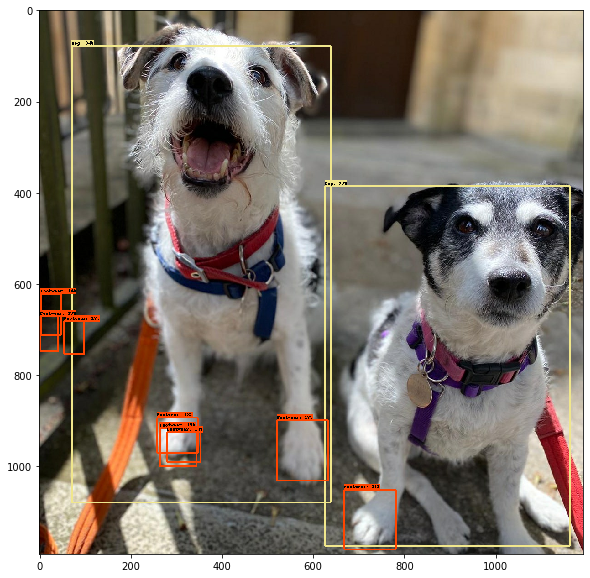

In [7]:
dog_img = 'twodogs.jpg'
run_detector(model, dog_img)

In [8]:
import os

In [9]:
os.getcwd()

'/opt/app-root/src/dog-detector-service'

## Create a Predict Function

Extract the prediction logic into a standalone python file, `prediction.py` in a `predict` function.  Also, make sure `requirements.txt` is updated with any additional packages you've used and need for prediction.

In [10]:
import tensorflow as tf
import base64

model_dir = 'models/openimages_v4_ssd_mobilenet_v2_1'
saved_model = tf.saved_model.load(model_dir)
detector = saved_model.signatures['default']


def predict(body):
    base64img = body.get('image')
    img_bytes = base64.decodebytes(base64img.encode())
    detections = detect(img_bytes)
    cleaned = clean_detections(detections)
    
    return { 'detections': cleaned }


def detect(img):    
    image = tf.image.decode_jpeg(img, channels=3)
    converted_img  = tf.image.convert_image_dtype(image, tf.float32)[tf.newaxis, ...]
    result = detector(converted_img)
    num_detections = len(result["detection_scores"])
    
    output_dict = {key:value.numpy().tolist() for key, value in result.items()}
    output_dict['num_detections'] = num_detections
    
    return output_dict


def clean_detections(detections):
    cleaned = []
    # max_boxes = 10
    # num_detections = min(detections['num_detections'], max_boxes)
    num_detections = detections['num_detections']

    for i in range(0, num_detections):
        label = detections['detection_class_entities'][i].decode('utf-8')
        score = detections['detection_scores'][i]
        if label == 'Dog' and score > 0.3:
            d = {
                'box': {
                    'yMin': detections['detection_boxes'][i][0],
                    'xMin': detections['detection_boxes'][i][1],
                    'yMax': detections['detection_boxes'][i][2],
                    'xMax': detections['detection_boxes'][i][3]
                },
                'class': label,
                'label': label,
                'score': score,
            }
            cleaned.append(d)

    return cleaned

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [11]:
import json

with open('sample-requests/twodogs.json') as json_file:
    data = json.load(json_file)
    
result = predict(data)
# print(len(result['detections']))
print(result['detections'])


[{'box': {'yMin': 0.06668734550476074, 'xMin': 0.059880733489990234, 'yMax': 0.9051148295402527, 'xMax': 0.5364789962768555}, 'class': 'Dog', 'label': 'Dog', 'score': 0.8483346700668335}, {'box': {'yMin': 0.32391250133514404, 'xMin': 0.5251951813697815, 'yMax': 0.9843556880950928, 'xMax': 0.9758182168006897}, 'class': 'Dog', 'label': 'Dog', 'score': 0.7970173358917236}]


## Test Predict Function

In [12]:
import json
from prediction import predict, detect


with open('sample-requests/twodogs.json') as json_file:
    data = json.load(json_file)
    
result = predict(data)
print(len(result['detections']))
print(result['detections'][0])



INFO:tensorflow:Saver not created because there are no variables in the graph to restore
2
{'box': {'yMin': 0.06668734550476074, 'xMin': 0.059880733489990234, 'yMax': 0.9051148295402527, 'xMax': 0.5364789962768555}, 'class': 'Dog', 'label': 'Dog', 'score': 0.8483346700668335}


### Run Flask

Run flask in a separate notebook ([1_run_flask.ipynb](./1_run_flask.ipynb)) to create a local service to try it out.  You must run the application in a separate notebook since it will use the kernel until stopped.

```
!FLASK_ENV=development FLASK_APP=wsgi.py flask run
```

### Test the Flask Endpoint

Head over to (notebook 4)[.4_run_flask.ipynb] to run the application, then visit (notebook 5)[5_test_flask.ipynb] to try out your model service. 